# 03-Reconstruction

We have so far learned how to generate the forward data and calculate the Jacobian. In this tutorial, you will learn two things that naturally extrapolates from past tutorials: how to simulate a blob in media, and how to perform reconstruction.

Please be noted, that the reconstruction part itself is not the focus of our NIRFASTer package, and designing the reconstruction algorithms is a complex topic that is far beyond the scope of this tutorial. The goal of this short tutorial is simply to give you a basic idea of the fundamental principles of DOT reconstruction. If you are interested in performing DOT reconstruction in human brain, it is recommended to take a look at some other packages that are dedicated to this purpose, e.g. [NeuroDOT](https://github.com/WUSTL-ORL/NeuroDOT_py). You may also want to have a look at [this paper](https://doi.org/10.1063/1.5086809).

Consider the linearized problem:
$$
\mathbf{y}=\mathbf{Ax}+\mathbf{\epsilon}
$$
where $\mathbf{y}$ is the measurement (e.g. log intensity change), $\mathbf{A}$ is the Jacobian matrix, $\mathbf{x}$ is the "brain activity" (e.g. $\mu_a$ change in the brain), and $\mathbf{\epsilon}$ is the measurement noise. The goal of DOT reconstruction is to estimate $\mathbf{x}$ given $\mathbf{y}$, and you may immediately recognize that this is nothing but a linear regression problem. The most widely-used method in the DOT community is called Tikhonov regularization (aka ridge regression), which solves the following problem,
$$
\mathbf{\hat{x}}=\arg\max_\mathbf{x}||\mathbf{y}-\mathbf{Ax}||^2+||\Gamma\mathbf{x}||^2
$$
where $\Gamma$ is the regularizer, which can either be a scalar of a matrix. If you are a Bayesian statistician, you may also notice that this is the maximum a posteriori (MAP) estimation of $\mathbf{x}$ when assuming that $cov(\epsilon)\propto\mathbf{I}$ and $cov(\mathbf{x})\propto\mathbf{\Gamma}^T\mathbf{\Gamma}$ ($\mathbf{\Gamma}=\Gamma\mathbf{I}$ if $\Gamma$ is scalar).

For brevity, we will only give an example using the 2D standard mesh. All other mesh types can be done in a very similar fashion, and it is left for the readers to explore.

In [1]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load mesh
mesh = ff.base.stndmesh()
mesh.from_file('../meshes/standard/circle2000_86_stnd')
# define the grid
xgrid = np.arange(-45., 45, 2)
ygrid = np.arange(-45., 45, 2)
mesh.gen_intmat(xgrid, ygrid)
# calculate the CW Jacobian for log amplitude
J = mesh.jacobian()[0]

Fixed sources
Sources integration functions loaded
Fixed detectors
Detectors integration functions loaded
Calculating direct field...
Calculating adjoint field...
Integrating...


Above codes are excatly the same as the first two cells of the previous tutorial, and we now already have the Jacobian matrix. Now let's add an anomaly, and calculated the log amplitude change.

In [18]:
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)
# add anomaly: a 1cm-radius disk centered at (15,15)
center = np.array([15., 15])
idx = np.nonzero(np.linalg.norm(mesh.nodes - center, axis=1)<10)[0] # indices of the nodes within the disk
# give it a 10% mua increase
mesh2.change_prop(idx, [mesh.mua[0]*1.1, mesh.mus[0], mesh.ri[0]])
# calculate data
data1 = mesh.femdata(0)[0]
data2 = mesh2.femdata(0)[0]
# now the optical density change
dOD = np.log(data2.amplitude) - np.log(data1.amplitude)
# add some noise: iid gaussian with std being 5% of the max
dOD += np.random.randn(dOD.size)*0.05*dOD.max()

Now we can do the reconstruction. Conveniently, NIRFASTer provides a simple Tikhonov regularization function to do exactly that. Here we stick with something simple: a scalar regularizer. In reality, you will need to adjust the regularizer according to your data. This can be done either empirically, or using methods e.g. [L-curve](https://www.sintef.no/globalassets/project/evitameeting/2005/lcurve.pdf) and [ReML](https://doi.org/10.1364/boe.1.001084). The general rule of thumb is, the larger the value, the smoother the results will be, but you loose the details; the smaller the value, the better resolution you get, but it can overfit to noise. This suggests that you need a larger regularizer for noisy data, and a smaller one for clean data.

<Figure size 640x480 with 0 Axes>

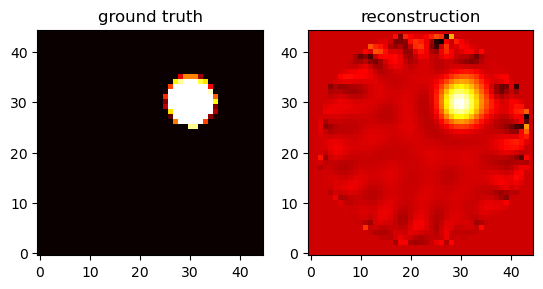

In [21]:
# reconstruction
dmua_recon = ff.inverse.tikhonov(J, 0.1, dOD)
# have a look
dmua_truth = np.reshape(mesh.vol.mesh2grid @ (mesh2.mua-mesh.mua), (45,45), order='F')

plt.set_cmap('hot')
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(dmua_truth, origin='lower')
ax1.set_title('ground truth')

ax2.imshow(dmua_recon.reshape((45,45), order='F'), origin='lower')
ax2.set_title('reconstruction')
plt.show()

Please be noted that this example is, as you may have gathered, highly simplified in many ways. For example, the noise added may not fully resemble what it should look like in realistic data, and you may need to change that.

The Tikhonov function can also handle non-scalar regularizers. The curious reader is highly encouraged to read the documentation and experiment with different regularizers.